# **Análise exploratória de dados(AED)**
#### Este notebook contem uma analise detalhada seguida de **vários modelos de machine learning com o intuito de predizer a quantidade de sobreviventes do titanic**, e ao final, exibir qual modelo teve maior acurácia

#### **Resumo do que será feito:** será realizada uma mineração dos dados, depois que os dados estiverem prontos, será feita uma simples predição das idades faltantes, apos isso, dará inicio **as predições de varios modelos para os sobreviventes.**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# **Lendo dataframe de treino e teste**

In [ ]:
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

# **Definindo o id do passageiro como index em ambos os dataframes**

In [ ]:
test.set_index("PassengerId",inplace=True)
train.set_index("PassengerId",inplace=True)


# **Concatenando os dataframes, exbindo o dataframe bruto**

In [ ]:
df = pd.concat([train, test],sort=True); df_bruto = pd.concat([train,test])
df.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599


# **Traduzindo Colunas**

In [ ]:

df.columns = ['Idade', 'Cabine', 'Embarque', 'Tarifa', 'Nome', 'Pais e Filhos', 'Classe', 'Sexo',
       'Irmaos Conjuge', 'Sobreviveu', 'Bilhete']

# **Traduzindo valores da coluna sexo**

In [ ]:
df["Sexo"].replace(["male","female"],["homem","mulher"],inplace=True)

#**Verificando dados faltantes**

In [ ]:
df.isnull().sum()

Idade              263
Cabine            1014
Embarque             2
Tarifa               1
Nome                 0
Pais e Filhos        0
Classe               0
Sexo                 0
Irmaos Conjuge       0
Sobreviveu         418
Bilhete              0
dtype: int64

### **Obs:** A cabine tem a maior quantidade de dados faltantes

#**Filtrando dados eliminando os inuteis, e alterando/preechendo pequenas porções de dados faltantes**

In [ ]:
df.drop("Cabine",axis=1,inplace=True)
df["Embarque"].fillna(df["Embarque"].mode()[0], inplace=True)
df["Tarifa"].fillna(df["Tarifa"].mean(), inplace=True)

#**Conferindo os dados faltantes depois de minerado**

In [ ]:
df.isnull().sum()

Idade             263
Embarque            0
Tarifa              0
Nome                0
Pais e Filhos       0
Classe              0
Sexo                0
Irmaos Conjuge      0
Sobreviveu        418
Bilhete             0
dtype: int64

# **Agrupamentos**
### **Agrupando classe X sobreviveu, agrupando quantidade de sobreviventes por classe**

In [ ]:
df[["Classe","Sobreviveu"]].groupby(["Classe"]).mean().sort_values(by="Sobreviveu",ascending=False)


,Sobreviveu
Classe,
1,0.629630
2,0.472826
3,0.242363


#####**Obs: os passageiros da primeira classe são mais propensos a sobreviver, ao contrario da terceira**

### **Agrupando sexo X sobreviveu**

In [ ]:
df[["Sexo","Sobreviveu"]].groupby("Sexo").mean().sort_values(by="Sobreviveu", ascending=False)

,Sobreviveu
Sexo,
mulher,0.742038
homem,0.188908


##### **Obs: Como podemos ver, grande parte dos sobreviventes foram do sexo femenino**

## **Média de idade por classe**

In [ ]:
mediaIdadePorClasse = df[["Classe","Idade"]].groupby("Classe").mean()
mediaIdadePorClasse["Idade"] =  mediaIdadePorClasse["Idade"].apply(lambda x:f"{x:.0f}")
mediaIdadePorClasse

,Idade
Classe,
1,39
2,30
3,25


##### **Obs: As pessoas da primeira classe eram mais velhas, consequentemente, as da terceira eram mais novas**

# **Visualização de dados**
### **Grafico de sobrevivência por sexo**

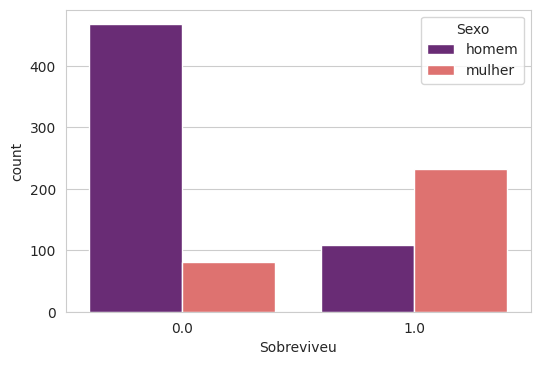

In [ ]:
plt.figure(dpi=100)
sns.set_style('whitegrid')
sns.countplot("Sobreviveu", hue="Sexo", data=df, palette="magma")
plt.show()

## **Chance de sobrevivência por porto de embarque**

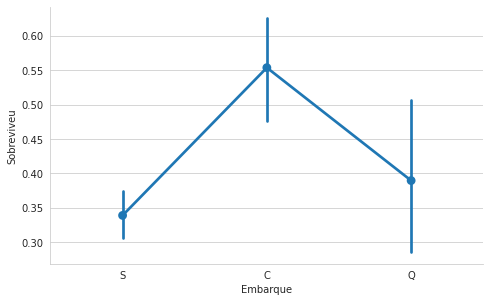

In [ ]:
sns.catplot('Embarque','Sobreviveu',data=df,kind='point')
fig = plt.gcf()
fig.set_size_inches(7,4)

##### **Obs: observamos que quem entrou pelo portão C, teve mais chances de sobrevivência**

## **Visualizando dados faltantes do dataframe**

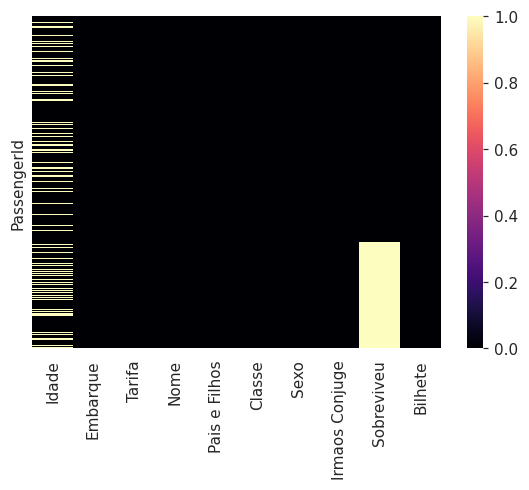

In [ ]:
plt.figure(dpi=110)
sns.heatmap(df.isnull(),cmap="magma",yticklabels=False)
plt.show()

# **Engenharia de recursos**
### **Descobrindo titulo das pessoas pelo nome**

In [ ]:
df["Titulo"] = df["Nome"].str.extract(r",\s([a-zA-Z]+)\.")
df["Titulo"] = df["Titulo"].apply(lambda x:x if x in "Mr Miss Mrs Master".split() else "Outros")

### **Traduzindo titulos**

In [ ]:
df["Titulo"].replace("Mr Miss Mrs Master".split(), "HomemAdulto Solteira Casada Menino".split(), inplace=True)

### **Pegando sobrenome dos passageiros para idenetificar possiveis familiares**

In [ ]:
df["Clan"] = df.Nome.apply(lambda x:x.split(",")[0])


## **Possiveis familias**

In [ ]:
df.groupby(["Clan"])["Nome"].count().sort_values(ascending=False)

Clan
Sage         11
Andersson    11
Asplund       8
Goodwin       8
Davies        7
             ..
Moutal        1
Moussa        1
Moss          1
Morrow        1
Abbing        1
Name: Nome, Length: 875, dtype: int64

### **Verificando Parentesco baseado  no sobrenome(Clan) e o bilhete**
##### **Verificando as possiveis maiores familias a bordo e sua taxa de sobrevivencia**
###### **Começando pela familia andersson**

In [ ]:
clanAndersson = df[["Sobreviveu","Classe","Titulo","Nome","Clan","Bilhete","Embarque"]].loc[(df['Clan'] == "Andersson")].dropna()
clanAndersson

,Sobreviveu,Classe,Titulo,Nome,Clan,Bilhete,Embarque
PassengerId,,,,,,,
14,0.0,3,HomemAdulto,"Andersson, Mr. Anders Johan",Andersson,347082,S
69,1.0,3,Solteira,"Andersson, Miss. Erna Alexandra",Andersson,3101281,S
120,0.0,3,Solteira,"Andersson, Miss. Ellis Anna Maria",Andersson,347082,S
147,1.0,3,HomemAdulto,"Andersson, Mr. August Edvard (""Wennerstrom"")",Andersson,350043,S
542,0.0,3,Solteira,"Andersson, Miss. Ingeborg Constanzia",Andersson,347082,S
543,0.0,3,Solteira,"Andersson, Miss. Sigrid Elisabeth",Andersson,347082,S
611,0.0,3,Casada,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",Andersson,347082,S
814,0.0,3,Solteira,"Andersson, Miss. Ebba Iris Alfrida",Andersson,347082,S
851,0.0,3,Menino,"Andersson, Master. Sigvard Harald Elias",Andersson,347082,S


# **Visualizando sobreviventes do clã Andersson por bilhetes**

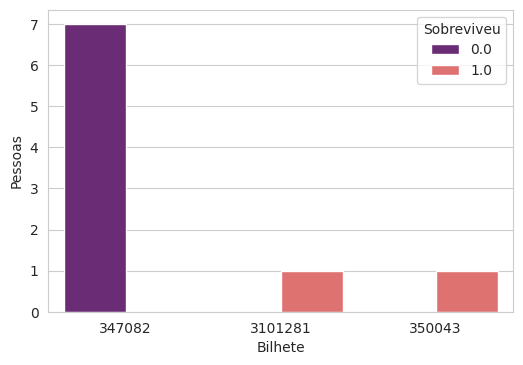

In [ ]:
plt.figure(dpi=100)
sns.set_style("whitegrid")
sns.countplot("Bilhete",data=clanAndersson,hue="Sobreviveu", palette="magma")
plt.ylabel("Pessoas")
plt.show()

##### **Obs: Verificamos que haviam 7 pessoas da familia Andersson com o mesmo bilhete, e todos nao sobreviveram**
##### **Obs 2: Tambem foi verificado que todos do clan Andersson entraram pelo portão S e sao da terceira classe**
# **Clã Sage**

In [ ]:
clanSage = df[["Sobreviveu","Classe","Titulo","Nome","Clan","Bilhete","Embarque"]].loc[(df['Clan'] == "Sage")].dropna()
clanSage

,Sobreviveu,Classe,Titulo,Nome,Clan,Bilhete,Embarque
PassengerId,,,,,,,
160,0.0,3,Menino,"Sage, Master. Thomas Henry",Sage,CA. 2343,S
181,0.0,3,Solteira,"Sage, Miss. Constance Gladys",Sage,CA. 2343,S
202,0.0,3,HomemAdulto,"Sage, Mr. Frederick",Sage,CA. 2343,S
325,0.0,3,HomemAdulto,"Sage, Mr. George John Jr",Sage,CA. 2343,S
793,0.0,3,Solteira,"Sage, Miss. Stella Anna",Sage,CA. 2343,S
847,0.0,3,HomemAdulto,"Sage, Mr. Douglas Bullen",Sage,CA. 2343,S
864,0.0,3,Solteira,"Sage, Miss. Dorothy Edith ""Dolly""",Sage,CA. 2343,S


##### **Obs: Verificamos que todos da familia Sage possuiam o mesmo bilhete, e todos nao sobreviveram**
##### **Obs 2: Tambem foi verificado que todos do clan Sage entraram pelo portão S e sao da terceira classe**

  # **Iniciando primeiro modelo preditivo para a idade**
  ### Verificando dados categóricos para converter pra dummy values, e eliminando colunas desnecessarias para o modelo

In [ ]:
df.head(2)

,Idade,Embarque,Tarifa,Nome,Pais e Filhos,Classe,Sexo,Irmaos Conjuge,Sobreviveu,Bilhete,Titulo,Clan
PassengerId,,,,,,,,,,,,
1,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,homem,1,0.0,A/5 21171,HomemAdulto,Braund
2,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,mulher,1,1.0,PC 17599,Casada,Cumings


## **Convertendo para Dummy**



In [ ]:
dfDummy = pd.get_dummies(df, columns=["Embarque","Classe","Titulo"], drop_first=True)
dfDummy["Sexo"].replace("homem mulher".split(),[0,1], inplace=True)

In [ ]:
dfDummy.drop(["Nome","Bilhete","Clan","Sobreviveu",],axis=1,inplace=True)
dfDummy.head(3)


,Idade,Tarifa,Pais e Filhos,Sexo,Irmaos Conjuge,Embarque_Q,Embarque_S,Classe_2,Classe_3,Titulo_HomemAdulto,Titulo_Menino,Titulo_Outros,Titulo_Solteira
PassengerId,,,,,,,,,,,,,
1,22.0,7.2500,0,0,1,0,1,0,1,1,0,0,0
2,38.0,71.2833,0,1,1,0,0,0,0,0,0,0,0
3,26.0,7.9250,0,1,0,0,1,0,1,0,0,0,1


# **Separando train e test para idade**
#### *Treinar com dados nao nulos
#### *Aplicar modelo em dados nulos


In [ ]:
dfDummy.isnull().sum()

Idade                 263
Tarifa                  0
Pais e Filhos           0
Sexo                    0
Irmaos Conjuge          0
Embarque_Q              0
Embarque_S              0
Classe_2                0
Classe_3                0
Titulo_HomemAdulto      0
Titulo_Menino           0
Titulo_Outros           0
Titulo_Solteira         0
dtype: int64

In [ ]:
train_idade = dfDummy.dropna()
test_idade = dfDummy[dfDummy['Idade'].isnull()].drop("Idade",axis=1)

# **Definindo X e y para treinar modelo**

In [ ]:
X = train_idade.drop("Idade",axis=1)
y = train_idade["Idade"]

In [ ]:
X.shape, y.shape

((1046, 12), (1046,))

## **Importar e instanciar modelo regressivo**

In [ ]:
from sklearn import linear_model
lm = linear_model.LinearRegression()

## **Efetuando treino**
#### Distribuindo 70% para treino e 30% para test

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30, random_state=123)

In [ ]:
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# **Predição**

In [ ]:
pred = lm.predict(Xtest)

# **Averiquando Score**

In [ ]:
lm.score(Xtest, ytest)

0.4223411308159648

# **Averiguando a margem de desvio padrão**

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ytest, pred)
rmse = np.sqrt(mse)
rmse

10.929054593804523

#### Obs: a margem de erro da idade é de 11 pra cima ou para baixo

# **Visualizando Residuos**

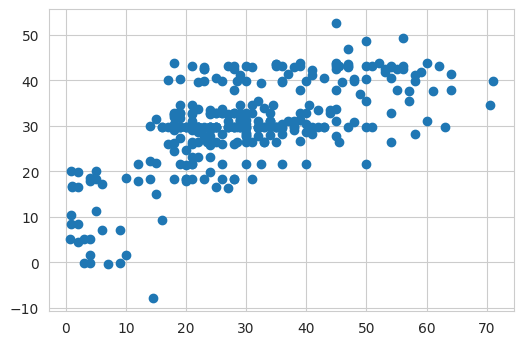

In [ ]:
plt.figure(dpi=100)
plt.scatter(ytest, pred)
plt.show()

# **Aplicando Modelo nos dados nulos**

In [ ]:
pred_idade = lm.predict(test_idade)

## **Verificando se há dados nulos depois da aplicação do modelo**

In [ ]:
test_idade["Idade"] = pred_idade
test_idade.isnull().sum()

Tarifa                0
Pais e Filhos         0
Sexo                  0
Irmaos Conjuge        0
Embarque_Q            0
Embarque_S            0
Classe_2              0
Classe_3              0
Titulo_HomemAdulto    0
Titulo_Menino         0
Titulo_Outros         0
Titulo_Solteira       0
Idade                 0
dtype: int64

# **Concatenando os dataframes novamente ja com as idades faltantes preenchidas pelo modelo**

In [ ]:
dfMinerado = pd.concat([test_idade,train_idade], sort=False)

# **Criando um dataframe apenas com a idade completa e seu respectivo id**

In [ ]:
idadeCompleta = pd.DataFrame({"IdPassageiro":dfMinerado.index,"Idade":dfMinerado["Idade"]})

In [ ]:
idadeCompleta.head()

,IdPassageiro,Idade
PassengerId,,
6,6,34.499919
18,18,32.864665
20,20,28.991280
27,27,26.437712
29,29,23.164838


## **Salvando o dataframe com a idade completa para futura análise**

In [ ]:
idadeCompleta.to_csv("idadeCompleta.csv", index=False)

# **----------------------------------------------------------------------------------------------------**

# **Finalizado primeiro modelo que preveu a idade faltante, iniciando o segundo modelo para predizer os campos faltantes da coluna Sobreviveu**

### Criando uma faixa etária baseado na idade como forma de deixar a idade categórica para conversão em dummy, com o intuito de potencializar o modelo preditivo com mais dados

.


In [ ]:
dfMinerado["Idade"] = dfMinerado["Idade"].astype(int)
dfMinerado["Faixa Etaria"] = pd.cut(dfMinerado["Idade"],bins=5)

In [ ]:
dfMinerado = pd.get_dummies(dfMinerado, columns=["Faixa Etaria"], drop_first=True)
dfMinerado.head()

,Tarifa,Pais e Filhos,Sexo,Irmaos Conjuge,Embarque_Q,Embarque_S,Classe_2,Classe_3,Titulo_HomemAdulto,Titulo_Menino,Titulo_Outros,Titulo_Solteira,Idade,"Faixa Etaria_(10.4, 27.8]","Faixa Etaria_(27.8, 45.2]","Faixa Etaria_(45.2, 62.6]","Faixa Etaria_(62.6, 80.0]"
PassengerId,,,,,,,,,,,,,,,,,
6,8.4583,0,0,0,1,0,0,1,1,0,0,0,34,0,1,0,0
18,13.0000,0,0,0,0,1,1,0,1,0,0,0,32,0,1,0,0
20,7.2250,0,1,0,0,0,0,1,0,0,0,0,28,0,1,0,0
27,7.2250,0,0,0,0,0,0,1,1,0,0,0,26,1,0,0,0
29,7.8792,0,1,0,1,0,0,1,0,0,0,1,23,1,0,0,0


## **Engenharia de recursos(Familiares)**
### Baseado nas colunas "irmaos Conjuge" e "Pais e Filhos"

In [ ]:
dfMinerado["Familiares"] = dfMinerado["Irmaos Conjuge"] + dfMinerado["Pais e Filhos"]

## **Visualizando correlação entre "Familiares", "Irmaos Conjuge" e "Pais e Filhos"**

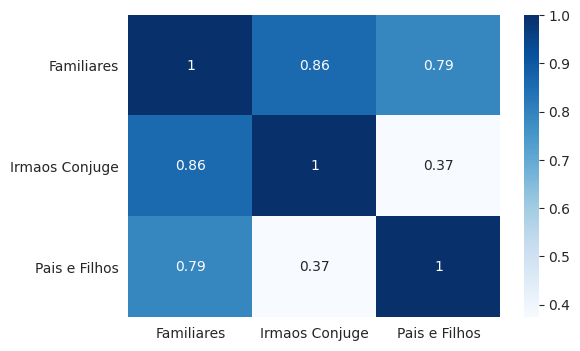

In [ ]:
plt.figure(dpi=100)
sns.heatmap(dfMinerado[["Familiares","Irmaos Conjuge","Pais e Filhos"]].corr(),annot=True,cmap="Blues")
plt.show()

#### Obs: Podemos observar que há 86% de correlação entre a coluna "Familiares" e "Irmaos Conjuge", e 79% de correlação entre "Pais e Filhos" e "Familiares"

# **Agora iremos preparar o dataframe para predizer os sobreviventes, para isso, iremos reinserir a coluna sobreviveu no dataframe ja minerado**

In [ ]:
dfMinerado["Sobreviveu"] = df["Sobreviveu"]

# **Atualizando o train e test**

In [ ]:
train = dfMinerado.loc[train.index]
test = dfMinerado.loc[test.index]
test.drop("Sobreviveu", axis=1, inplace=True)

# **Treinando o modelo so com o train**

In [ ]:
X = train.drop("Sobreviveu", axis=1)
y = train["Sobreviveu"]

In [ ]:
X.shape, y.shape

((891, 18), (891,))

#### **Escolhendo colunas ideais para o modelo**

In [ ]:

colunas = ['Tarifa', 'Pais e Filhos', 'Sexo', 'Irmaos Conjuge', 'Embarque_Q',
       'Embarque_S', 'Classe_2', 'Classe_3', 'Titulo_HomemAdulto',
       'Titulo_Menino', 'Titulo_Outros', 'Titulo_Solteira', 'Idade',
       'Faixa Etaria_(10.4, 27.8]', 'Faixa Etaria_(27.8, 45.2]',
       'Faixa Etaria_(45.2, 62.6]', 'Faixa Etaria_(62.6, 80.0]', 'Familiares']

X = X[colunas]
X.head()

,Tarifa,Pais e Filhos,Sexo,Irmaos Conjuge,Embarque_Q,Embarque_S,Classe_2,Classe_3,Titulo_HomemAdulto,Titulo_Menino,Titulo_Outros,Titulo_Solteira,Idade,"Faixa Etaria_(10.4, 27.8]","Faixa Etaria_(27.8, 45.2]","Faixa Etaria_(45.2, 62.6]","Faixa Etaria_(62.6, 80.0]",Familiares
PassengerId,,,,,,,,,,,,,,,,,,
1,7.2500,0,0,1,0,1,0,1,1,0,0,0,22,1,0,0,0,1
2,71.2833,0,1,1,0,0,0,0,0,0,0,0,38,0,1,0,0,1
3,7.9250,0,1,0,0,1,0,1,0,0,0,1,26,1,0,0,0,0
4,53.1000,0,1,1,0,1,0,0,0,0,0,0,35,0,1,0,0,1
5,8.0500,0,0,0,0,1,0,1,1,0,0,0,35,0,1,0,0,0


#### **Dividindo em 70% treino e 30% test**

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=123)

# **Machine Learning**
### **Importando modelos para testar a acuracidade de cada um e ver qual acertou mais**

In [ ]:
from sklearn.ensemble import (AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              ExtraTreesClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## **Criação de classe para auxiliar a execução dos modelos importados**
##### será uma classe para evitar repetições de códigos desnecessária

In [ ]:
class ModeloAuxiliar(object):
    def __init__(self, clf, seed=123, params=None):
        if params:
            params['random_state'] = seed
            self.clf = clf(**params)
        else:
            self.clf = clf()
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    
    def score(self,x,y):
        return self.clf.score(x,y)

## **Dicionario de Modelos Preditivos**

In [ ]:
modelos = [{'nome': 'Logistic Regression',
            'modelo': LogisticRegression},
           {'nome':'Linear Regression',
            'modelo':LinearRegression},
           {'nome': 'etree',
            'modelo': ExtraTreesClassifier},
           {'nome': 'gradboost',
             'modelo': GradientBoostingClassifier}, 
           {'nome': 'adaboost',
             'modelo': AdaBoostClassifier},
           {'nome': 'SVC',
            'modelo': SVC},
           {'nome': 'KNN',
            'modelo': KNeighborsClassifier},
           {'nome': 'GaussianNB',
            'modelo': GaussianNB},
           {'nome': 'Perceptron',
            'modelo': Perceptron},
           {'nome': 'LinearSVC',
            'modelo': LinearSVC},
           {'nome': 'SGD',
            'modelo': SGDClassifier},
           {'nome': 'Dtree',
            'modelo': DecisionTreeClassifier},
           {'nome': 'RForest',
            'modelo': RandomForestClassifier}
          ]

## **Executando varios modelos preditivos de uma vez**

In [ ]:
resultados = []
for model in modelos:
    x = ModeloAuxiliar(clf=model['modelo'])
    # treinar o modelo
    x.fit(Xtrain, ytrain)
    
    # gerar predicao
    x_pred = x.predict(Xtest)
    
    # gerar score
    acuracidade = round(x.score(Xtest,ytest)*100,2)
    
    resultados.append({'nome': model['nome'],
                       'score': acuracidade,
                       'pred': x_pred })

# **Ranking de Modelos Por Score**
###### [Voltar para início](#topo)


In [ ]:

models = pd.DataFrame(resultados)
modelos = models[['nome','score']].sort_values(by='score', ascending=False)
modelos

,nome,score
3,gradboost,85.45
4,adaboost,83.96
0,Logistic Regression,82.84
12,RForest,82.46
9,LinearSVC,79.85
2,etree,79.48
7,GaussianNB,79.48
11,Dtree,76.12
5,SVC,72.76
6,KNN,72.76
